<a href="https://colab.research.google.com/github/gauravreddy08/pytorch-vision-transformer/blob/main/vit_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating **Vision Transformer** using **PyTorch**

<img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="550">

> **Vision Transformer Paper:** [**An image is worth 16x16 words**](https://arxiv.org/abs/2010.11929)

> **Original Transformer Paper:** [**Attention is all you need**](https://arxiv.org/abs/1706.03762)

In [1]:
!pip install -q torchinfo wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
import torchvision
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

def set_seed(seed: int = 42):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

Device: cpu


In [3]:
# Self Made helper_functions to ease our model development and training process
# Visit : https://github.com/gauravreddy08/learning-pytorch/tree/main/going_modular

!git clone https://github.com/gauravreddy08/learning-pytorch
!mv /content/learning-pytorch/going_modular .
!rm -rf learning-pytorch

Cloning into 'learning-pytorch'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 59 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), 1.77 MiB | 7.22 MiB/s, done.


In [4]:
# Initiating WandB project 
run = wandb.init(project="vit-replication")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Downloading the **dataset**

> **Source:** [`github.com/mrdbourke/pytorch-deep-learning/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip)

In [5]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    data = Path("data/")
    data_path = data /destination
    if(data_path.is_dir()):
      print("[INFO] Data already exists...")
    else:
      print(f"[INFO] Did not find {data_path} directory, creating one...")
      data_path.mkdir(parents=True, exist_ok=True)

      target_file = Path(source).name
      with open(data/target_file, 'wb') as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)
      with zipfile.ZipFile(data/target_file, 'r') as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...")
        zip_ref.extractall(data_path)
      if remove_source:
        os.remove(data/target_file)

    return data_path

data_path = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
                          destination='pizaa_steak_sushi')

train_dir = data_path/'train'
test_dir = data_path/'test'

print(f"Training Directory: {train_dir}")
print(f"Testing Directory: {test_dir}")

[INFO] Did not find data/pizaa_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
Training Directory: data/pizaa_steak_sushi/train
Testing Directory: data/pizaa_steak_sushi/test


## Turning **data** into **dataloaders**

In [6]:
from torchvision import transforms

IMG_SIZE = (224, 224) # Table 3
BATCH_SIZE = 32 # paper used 4096, we don't have computation power

# Creating transforms
manual_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [7]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataset(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms)

In [8]:
imgs, labels = next(iter(train_dataloader))
image, label = imgs[0], labels[0]

print(f"Image Shape: {image.shape}")
print(f"Example Label: {label}")

Image Shape: torch.Size([3, 224, 224])
Example Label: 0


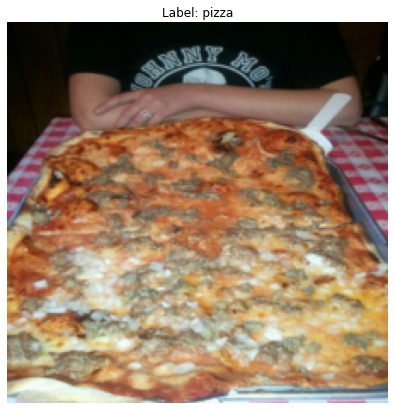

In [9]:
plt.figure(figsize=(7, 7))

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.axis('off');

## Building the **ViT** Model 

### **Part I: Input to our Architecture**

<img src="https://raw.githubusercontent.com/gauravreddy08/pytorch-vision-transformer/main/assets/architecture.png" alt="Architecture " width="550">

#### **Decoding the Architecture:** 
The **ViT architecture** is heavily inspired by the Transformer architecture (hence the name **"Vision Transformer"**). Instead of looking at the data as a whole, these networks focus and give "attention" to specific parts of data or an image, in our case. In a **Vision Transformer (ViT)**, the input image is first divided into smaller patches, and each patch is treated like a word in a sentence. The patches are then processed by a *transformer encoder* that's been adapted for image analysis.

So as an initial input through our network, images are resized and cropped into several different **patches**. These patches are then passed through the *transformer encoder* as **1D Tensors**. Also, each patch (image) is coupled with its respective **"positional embedding"**. And there's an extra learnable **"classification token [CLS]"** prepended in the sequence of embeddings.

> **What should be the target size of the input image?**
> 
> The target size of the input image should be 224x224. 
> > Refer table [4](https://arxiv.org/pdf/2010.11929.pdf#page=5).

> **What number of patches are extracted from a image? `3x3`? `5x5`? `10x10`?**
>
> The Base-ViT model, also commonly known as ViT16, utilizes 16x16 sized patches resulting in a total of 196 patches. 
> > Refer page [5](https://arxiv.org/pdf/2010.11929.pdf#page=5). 
``` 
 14 * 14 = 196 + 1 (CLS token) = 197
```

> **What should the dimension of the then transformed 1D Tensors be?**
> 
> The dimension of the transformed 1D Tensors should be 768. Not so coincidentally, when a patch image (3 x 16 x 16) is flattened and reshaped into a 1D tensor, we end up with a 768 dimension tensor.
>
> ```python
> [16 x 16 x 3] -> nn.Flatten() -> [1 x 768]
> ```
>
> > Refer Table [1](https://arxiv.org/pdf/2010.11929.pdf#page=5).

> **What exact layers are used to generate the image embeddings?**
>
> ViT uses **Conv2D layers** for both generating embeddings while also dividing the input image into patches. 
>
> You may ask, how can we *patchify* the image using conv layers ? 
>
> The Conv2D layers patchify the image using kernel size and stride. Specifically, setting the `kernel_size` and `stride` to 16, we can parse over the image as 16 by 16 blocks and generate the embeddings. More about this can be found in the code.

> **What's the extra learnable "classification token" mentioned?**
>
> The **Class Token** is randomly initialized and doesn’t contain any useful information on its own. However, the **Class Token** accumulates information from the other tokens in the sequence the deeper and more layers the Transformer is. 

> When the Vision Transformer finally performs the final classification of the sequence, it uses an MLP head which only looks at data from the last layer’s Class Token and no other information. [`source`](https://deepganteam.medium.com/vision-transformers-for-computer-vision-9f70418fe41a)

> **What's a positional embedding?**
> 
> The position of a patch relative to the whole image proves to be crucial information. For example, the whitespace in "the rapist" and "therapist." Transformers, unlike LSTMs, take inputs in parallel and all at once, which means they lose information about the sequence of these patches. To avoid this, we couple each image embedding with its respective positional embedding. [`source`](https://www.youtube.com/watch?v=dichIcUZfOw&ab_channel=HeduAI)




$$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}$$

Equation 1 pretty much sums up the whole above content into a mathematical form. 

But, how about a psuedo code ? 

**Equation 1 Psuedo Code :**
```python
x_input = [class_token, patch_1, patch_2, ..., patch_N] + [pos_0, pos_1, pos_2, ..., pos_N]

```

In [10]:
width = 224
height = 224
channels = 3

patch_size = 16
patch_count = int((width*height)/(patch_size**2))
print(f"Number of Patches (N) = {patch_count}")

Number of Patches (N) = 196


Interesting... The number of patches in a **224 x 224** image is **196**.

Now let's convert them into a 1D Tensors.

In [11]:
dummy_patch = torch.randn(patch_count, 16, 16, 3)
dummy_patch.shape

torch.Size([196, 16, 16, 3])

In [12]:
final_one_d_tensor = nn.Flatten()(dummy_patch)
print(f"Final 1D Tensors Size: {final_one_d_tensor.shape} -> (number of patches, embedding size)")

Final 1D Tensors Size: torch.Size([196, 768]) -> (number of patches, embedding size)


### Converting **images** into **patches** with `nn.Conv2D` layers

In [13]:
image_permuted = image.permute(1, 2, 0)
image_permuted.shape

torch.Size([224, 224, 3])

In [14]:
patch_embedding = nn.Conv2d(in_channels=3, out_channels=768, # 16*16*3
                   kernel_size=16, stride=16, padding=0)
patch_embedding

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [15]:
input_image = image.unsqueeze(dim=0)

In [16]:
patch_embedding.eval()

with torch.inference_mode():
  pred = patch_embedding(input_image)

print(f"Shape of Input Image: {input_image.shape}")
print(f"Shape of patched image: {pred.shape}")

Shape of Input Image: torch.Size([1, 3, 224, 224])
Shape of patched image: torch.Size([1, 768, 14, 14])
